# Neural Style Transfer of building styles

This notebook aims to test the applicability of Neural Style Transfer to city themes, for example can you change the look and feel of a city to make it look more modern, derelict, or even make it look like a desert city.

This is a prelude to attempting this with video.

Code from https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the images

In [7]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    # Fake batch dimensions to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader('./images/44.png')
content_img = image_loader('images/st-peters-square.png')

assert style_img.size() == content_img.size(), \
    'We need to import style and content images of the same size'

torch.Size([1, 3, 512, 910]) torch.Size([1, 3, 512, 910])


Function to reconvert the image to its PIL format

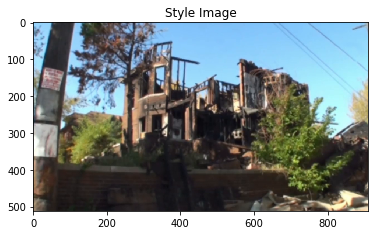

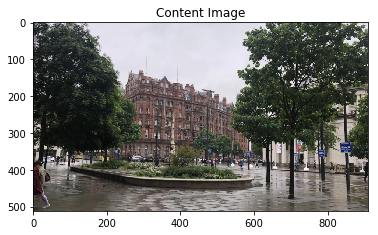

In [9]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

### Loss Functions

* Content Loss

In [24]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

* Style Loss

In [25]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [26]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Import trained VGG19 model

In [13]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/mark_strefford/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:28<00:00, 20146375.03it/s]


In [27]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Create module to normalize input image so we can easily put it in a 
# nn.Sequential

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # View the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W]
        # B = batch size, C = channels, H x W
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

            
    def forward(self, img):
        return (img - self.mean) / self.std

### Add content and style losses to network

In [15]:
content_layers_default = ['conv4d']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std, 
                              style_img, content_img, 
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    
    cnn = copy.deepcopy(cnn)
    
    # Normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    # iterable access to list of content / style losses
    content_losses = []
    style_losses = []
    
    # Assume cnn is Sequentiual, so we can make a new nn.Sequential
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The inplace version doesn't play well with contentloss
            # and styleloss so we replace with out-of-place
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RunTimeError('Unrecognized layer {}'.format(layer.__class__.__name__))
       
        model.add_module(name, layer)
        
        if name in content_layers:
            # Add content loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module('content_loss_{}'.format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
             # Add style layers
                target_feature = model(style_img).detach()
                style_loss = StyleLoss(target_feature)
                model.add_module('style_loss_{}'.format(i), style_loss)
                style_losses.append(style_loss)
                
        # Now trim off the layers after the last content and style losses
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break
        
        model = model[:(i + 1)]
        
        return model, style_losses, content_losses

Next select the input image. 

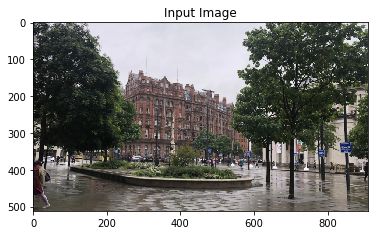

In [28]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

### Gradient descent

In [29]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [31]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score, content_score))
                    # style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]:
Style Loss : 0.000092 Content Loss: 0.000000

run [100]:
Style Loss : 5102.193359 Content Loss: 0.000000

run [150]:
Style Loss : 28.662439 Content Loss: 0.000000

run [200]:
Style Loss : 0.005083 Content Loss: 0.000000

run [250]:
Style Loss : 0.000052 Content Loss: 0.000000

run [300]:
Style Loss : 0.000019 Content Loss: 0.000000



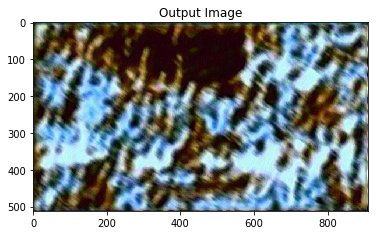

In [34]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()